In [1]:
import pandas as pd
import numpy as np
import networkx as nx

# LncRNA- Disease Dataset
Total no. of lncRNAs= 240

Total no of Diseases= 412

Total no of miRNAs = 495

Total no. of lnc-Dis interaction = 2697

In [2]:
lncrnas = pd.read_csv('lncRNAs.csv',sep='\t')
lncrnas = list(lncrnas['lncrna'])

diseases = pd.read_csv('diseases.csv',sep='\t')
diseases =list(diseases['disease'])

mirnas = pd.read_csv('miRNAs.csv',sep='\t')
mirnas = list(mirnas['mirna'])

print("Lnc=",len(lncrnas),"miRNA=",len(mirnas),"Diseases=",len(diseases))

Lnc= 240 miRNA= 495 Diseases= 412


In [3]:
def name2id(names,label):
    name2id_dic = {}
    n=1
    for name in names:
        name2id_dic[name]=label+str(n)
        n+=1
    return name2id_dic

def id2name(ids):
    pass



In [5]:
lnc2id = name2id(lncrnas,'L')
mir2id = name2id(mirnas, 'M')
dis2id = name2id(diseases,'D')

lncIdx = [lnc2id[lnc] for lnc in lncrnas]
mirIdx = [mir2id[mir] for mir in mirnas]
disIdx = [dis2id[dis] for dis in diseases]

#lncIdx[:10],mirIdx[:10],disIdx[:10]

In [6]:
lnc_dis_df = pd.read_csv('lncRNA-disease.csv')
lnc_dis_df.shape

(240, 413)

In [7]:
temp ={}
for dis in disIdx:
    temp[dis]=lnc_dis_df[dis].values
lnc_dis_dict={}

n=0
for lnc in lncIdx:
    t={}
    for dis in disIdx:
        t[dis]=temp[dis][n]
    lnc_dis_dict[lnc]=t
    n+=1

#temp['D2'].shape,len(lnc_dis_dict['L45'])
#print(lnc_dis_dict['L2'])
    
#lnc_dis_df.head(2)
        

In [8]:
lnc_dis_adj_list = []
for lnc in lncIdx:
    for dis in disIdx:
        lnc_dis_adj_list.append((lnc,dis,lnc_dis_dict[lnc][dis]))
len(lnc_dis_adj_list)

98880

In [9]:
pos=[]
pos_lnc =[]
pos_dis =[]
for lnc in lncIdx:
    for dis in disIdx:
        if lnc_dis_dict[lnc][dis]>0:
            pos.append((lnc,dis,1))
            if lnc not in pos_lnc: pos_lnc.append(lnc)
            if dis not in pos_dis: pos_dis.append(dis)
print (len(pos_lnc),len(pos_dis),len(pos))


181 412 2697


In [10]:
neg_all=[]
for lnc in lncIdx:
    for dis in disIdx:
        if lnc_dis_dict[lnc][dis]==0:
            neg_all.append((lnc,dis,0))

print(len(neg_all))

96183


In [11]:
import random
random.seed(1024)
neg = random.sample(neg_all,2697)

In [12]:
len(set([l[0] for l in neg])),len(set([l[1] for l in neg])),len(neg)

(240, 409, 2697)

In [13]:
random.shuffle(pos)
random.shuffle(neg)

In [14]:
total = len(pos)
train = pos[:int(total*0.8)]
train += neg[:int(total*0.8)]
test = pos[int(total*0.8):]
test += neg[int(total*0.8):]
len(train),len(test)

(4314, 1080)

In [15]:
random.shuffle(train)
random.shuffle(test)

In [16]:
fp=open('X_train.txt','w')
[fp.write(pair[0]+','+pair[1]+'\n') for pair in train]
fp.close()

fp=open('X_test.txt','w')
[fp.write(pair[0]+','+pair[1]+'\n') for pair in test]
fp.close()

fp=open('y_train.txt','w')
[fp.write(str(pair[2])+'\n') for pair in train]
fp.close()

fp=open('y_test.txt','w')
[fp.write(str(pair[2])+'\n') for pair in test]
fp.close()

# LDA: LncRNA-Disease Network

In [17]:
lnc_dis_adj_list = []
s=0
fp=open('lda.edgelist','w')
for lnc in lncIdx:
    for dis in disIdx:
        s+=int(bool(fp.write(lnc+'\t'+dis+'\t'+str(lnc_dis_dict[lnc][dis])+'\n')))
print(s)
fp.close()


98880


In [18]:
lda_graph = nx.read_weighted_edgelist('lda.edgelist',delimiter="\t")
lda_adj = nx.adjacency_matrix(lda_graph)
lda_adj.shape

(652, 652)

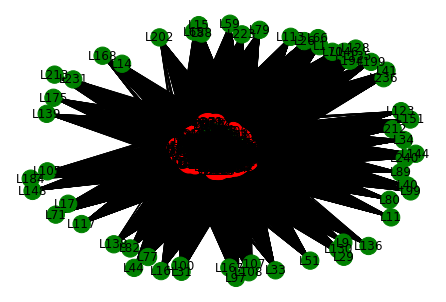

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

nx.draw(lda_graph,node_color=colors, cmap = plt.get_cmap('rainbow'), with_labels=True,pos=nx.spring_layout (lda_graph))

In [19]:
print("Before:",lda_graph.number_of_nodes(),lda_graph.number_of_edges())
for edge in lda_graph.edges:
    if lda_graph.get_edge_data(edge[0],edge[1])['weight']<=0.0:
        lda_graph.remove_edge(edge[0],edge[1])
print("After:",lda_graph.number_of_nodes(),lda_graph.number_of_edges())

Before: 652 98880
After: 652 2697


In [20]:
from node2vec import Node2Vec

unable to import 'smart_open.gcs', disabling that module


In [21]:
node2vec = Node2Vec(lda_graph, dimensions=64, walk_length=10, num_walks=100, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 652/652 [00:01<00:00, 395.50it/s]


In [22]:
ld_l_vec={}
for lnc in lncIdx:
    ld_l_vec[lnc]=model.wv.get_vector(lnc)

ld_d_vec={}
for dis in disIdx:
    ld_d_vec[dis]=model.wv.get_vector(dis)

len(ld_l_vec),len(ld_d_vec)

(240, 412)

In [23]:
X_train_ld =[]
for ld in train:
    ld_vec = np.concatenate((ld_l_vec[ld[0]],ld_d_vec[ld[1]]))
    X_train_ld.append(ld_vec)
X_train_ld = np.array(X_train_ld)

X_test_ld =[]
for ld in test:
    ld_vec = np.concatenate((ld_l_vec[ld[0]],ld_d_vec[ld[1]]))
    X_test_ld.append(ld_vec)
X_test_ld = np.array(X_test_ld)

X_train_ld.shape, X_test_ld.shape

((4314, 128), (1080, 128))

In [24]:
np.save('X_train_ld.npy',X_train_ld)
np.save('X_test_ld.npy',X_test_ld)

# LMS: lncRNA-miRNA-lncRNA interaction network

In [25]:
lnc_mir_df = pd.read_csv('lncRNA-miRNA.csv',sep='\t')
lnc_mir_df.shape

(240, 496)

In [ ]:
#lnc_mir_df.values[0][1:]

In [26]:
lnc_mir_values=lnc_mir_df.values
lnc_mir_dic={}
for i in range(lnc_mir_df.shape[0]):
    lnc = lnc_mir_values[i][0]
    lnc_mir_dic[lnc]={mirIdx[j-1]:lnc_mir_values[i][j] for j in range(1,lnc_mir_df.shape[1])}
#lnc_mir_dic['L1']['M2']

In [44]:
count=0
pos_lnc_mir =[]
pos_mir =[]
for lnc in lncIdx:
    for mir in mirIdx:
        if lnc_mir_dic[lnc][mir]>0:
            count+=1
            if lnc not in pos_lnc_mir:
                pos_lnc_mir.append(lnc)
            if mir not in pos_mir:
                pos_mir.append(mir)
print(len(pos_lnc_mir),len(pos_mir),count)

49 232 1002


In [27]:
fp = open('lnc_mir.edgelist','w')
for lnc in lncIdx:
    for mir in mirIdx:
        fp.write(lnc+'\t'+mir+'\t'+str(lnc_mir_dic[lnc][mir])+'\n')
fp.close()


In [28]:
lnc_mir_graph = nx.read_weighted_edgelist('lnc_mir.edgelist',delimiter='\t')
#nx.draw(lnc_mir_graph, cmap = plt.get_cmap('rainbow'), with_labels=True,pos=nx.spring_layout (lnc_mir_graph))

In [29]:
lnc_lnc_df = pd.read_csv('lncRNA-lncRNA.csv',sep='\t')
lnc_lnc_values=lnc_lnc_df.values
lnc_lnc_dic={}
for i in range(lnc_lnc_df.shape[0]):
    lnc = lnc_lnc_df.values[i][0]
    lnc_lnc_dic[lnc]={lncIdx[j-1]:lnc_lnc_values[i][j] for j in range(1,lnc_lnc_df.shape[1])}


In [30]:
fp = open('lnc_lnc.edgelist','w')
for lnc1 in lncIdx:
    for lnc2 in lncIdx:
        fp.write(lnc1+'\t'+lnc2+'\t'+str(lnc_lnc_dic[lnc1][lnc2])+'\n')
fp.close()

In [31]:
lnc_lnc_edges = open('lnc_lnc.edgelist').read()
lnc_mir_edges = open('lnc_mir.edgelist').read()
fp= open('lnc_mir_lnc.edgelist','w')
fp.write(lnc_lnc_edges)
fp.write(lnc_mir_edges)
fp.close()

In [32]:
lml_graph = nx.read_weighted_edgelist('lnc_mir_lnc.edgelist',delimiter='\t')

In [33]:
print("Before:",lml_graph.number_of_nodes(),lml_graph.number_of_edges())
for edge in lml_graph.edges:
    if lml_graph.get_edge_data(edge[0],edge[1])['weight']<=0.0:
        lml_graph.remove_edge(edge[0],edge[1])
print("After:",lml_graph.number_of_nodes(),lml_graph.number_of_edges())

Before: 735 147720
After: 735 17532


In [34]:
node2vec = Node2Vec(lml_graph, dimensions=64, walk_length=10, num_walks=100, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 735/735 [00:37<00:00, 19.81it/s] 


In [35]:
lm_l_vec={}
for lnc in lncIdx:
    lm_l_vec[lnc]=model.wv.get_vector(lnc)

In [36]:
lm_l_vec['L2'].shape

(64,)

# DMS: Disease- miRNA- Disease Network

In [37]:
dis_mir_df = pd.read_csv ('miRNA-disease.csv',sep='\t', header=None)
dis_mir_df = dis_mir_df.transpose()
dis_mir_df.shape

(412, 495)

In [38]:
dis_mir_values=dis_mir_df.values
dis_mir_dic={}
for i in range(dis_mir_df.shape[0]):
    dis = disIdx[i]
    dis_mir_dic[dis]={mirIdx[j]:dis_mir_values[i][j] for j in range(dis_mir_df.shape[1])}


In [39]:
dis_dis_df = pd.read_csv ('disease-disease.csv',sep='\t', header=None)
dis_dis_df.shape

(412, 412)

In [40]:
dis_dis_values=dis_dis_df.values
dis_dis_dic={}
for i in range(dis_dis_df.shape[0]):
    dis = disIdx[i]
    dis_dis_dic[dis]={disIdx[j]:dis_dis_values[i][j] for j in range(dis_dis_df.shape[1])}


In [41]:
dis_mir_edges=''
for dis in disIdx:
    for mir in mirIdx:
        dis_mir_edges+=dis+'\t'+mir+'\t'+str(dis_mir_dic[dis][mir])+'\n'

dis_dis_edges =''
for dis in disIdx:
    for dis in disIdx:
        dis_dis_edges+=dis+'\t'+dis+'\t'+str(dis_dis_dic[dis][dis])+'\n'

fp = open('dis_mir_dis.edgelist','w')
fp.write(dis_mir_edges+dis_dis_edges)
fp.close()

In [42]:
dmd_graph = nx.read_weighted_edgelist('dis_mir_dis.edgelist',delimiter='\t')

In [43]:
print("Before:",dmd_graph.number_of_nodes(),dmd_graph.number_of_edges())
for edge in dmd_graph.edges:
    if dmd_graph.get_edge_data(edge[0],edge[1])['weight']<=0.0:
        dmd_graph.remove_edge(edge[0],edge[1])
print("After:",dmd_graph.number_of_nodes(),dmd_graph.number_of_edges())

Before: 907 204352
After: 907 13974


In [44]:
node2vec = Node2Vec(dmd_graph, dimensions=64, walk_length=10, num_walks=100, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 907/907 [00:18<00:00, 49.20it/s] 


In [45]:
dm_d_vec={}
for dis in disIdx:
    dm_d_vec[dis]=model.wv.get_vector(dis)

## Combine node vectors from LMS and DMS networks 

In [46]:
X_train_lmd =[]
for ld in train:
    ld_vec = np.concatenate((lm_l_vec[ld[0]],dm_d_vec[ld[1]]))
    X_train_lmd.append(ld_vec)
X_train_lmd = np.array(X_train_lmd)

X_test_lmd =[]
for ld in test:
    ld_vec = np.concatenate((lm_l_vec[ld[0]],dm_d_vec[ld[1]]))
    X_test_lmd.append(ld_vec)
X_test_lmd = np.array(X_test_lmd)

X_train_lmd.shape, X_test_lmd.shape

((4314, 128), (1080, 128))

In [47]:
np.save('X_train_lmd.npy',X_train_lmd)
np.save('X_test_lmd.npy',X_test_lmd)